## Testing averaging methods
From [this post](https://fvt.simulkade.com/posts/2015-04-20-choosing-the-right-averaging-method-for-fvm.html)

The equation is: $$\frac{\partial\phi}{\partial t}+\nabla . (-D(\phi)\nabla \phi) =0$$

In [58]:
from fipy import Grid2D, CellVariable, FaceVariable
import numpy as np


def upwindValues(mesh, field, velocity):
    """Calculate the upwind face values for a field variable

    Note that the mesh.faceNormals point from `id1` to `id2` so if velocity is in the same
    direction as the `faceNormal`s then we take the value from `id1`s and visa-versa.

    Args:
      mesh: a fipy mesh
      field: a fipy cell variable or equivalent numpy array
      velocity: a fipy face variable (rank 1) or equivalent numpy array
     
    Returns:
      numpy array shaped as a fipy face variable
    """
    # direction is over faces (rank 0)
    direction = np.sum(np.array(mesh.faceNormals * velocity), axis=0)
    # id1, id2 are shaped as faces but contains cell index values
    id1, id2 = mesh._adjacentCellIDs
    return np.where(direction >= 0, field[id1],  field[id2])

In [3]:
from fipy import *
import numpy as np

$$\frac{\partial\phi}{\partial t}+\nabla . \left(-D\left(\phi_{0}\right)\nabla \phi\right)+\nabla.\left(-\nabla \phi_{0}\left(\frac{\partial D}{\partial \phi}\right)_{\phi_{0,face}}\phi\right) =\nabla.\left(-\nabla \phi_{0}\left(\frac{\partial D}{\partial \phi}\right)_{\phi_{0,face}}\phi_{0,face}\right)$$

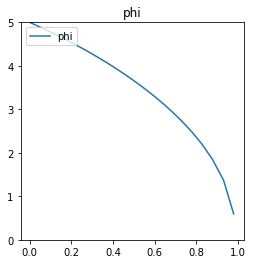

In [47]:
L= 1.0 # domain length
Nx= 100
dx_min=L/Nx
x=np.array([0.0, dx_min])
while x[-1]<L:
    x=np.append(x, x[-1]+1.05*(x[-1]-x[-2]))
x[-1]=L

mesh = Grid1D(dx=dx)

phi = CellVariable(mesh=mesh, name="phi", hasOld=True, value = 0.0)
phi.constrain(5.0, mesh.facesLeft)
phi.constrain(0., mesh.facesRight)

# D(phi)=D0*(1.0+phi.^2)
# dD(phi)=2.0*D0*phi
D0 = 1.0
dt= 0.01*L*L/D0 # a proper time step for diffusion process

eq = TransientTerm(var=phi) - DiffusionTerm(var=phi, coeff=D0*(1+phi.faceValue**2))

for i in range(4):
    for i in range(5):
        c_res = eq.sweep(dt = dt)
    phi.updateOld()

Viewer(vars = phi, datamax=5.0, datamin=0.0);
# viewer.plot()

$$\frac{\partial\phi}{\partial t}+\nabla . \left(-D\left(\phi_{0}\right)\nabla \phi\right)+\nabla.\left(-\nabla \phi_{0}\left(\frac{\partial D}{\partial \phi}\right)_{\phi_{0,face}}\phi\right) =\nabla.\left(-\nabla \phi_{0}\left(\frac{\partial D}{\partial \phi}\right)_{\phi_{0,face}}\phi_{0,face}\right)$$

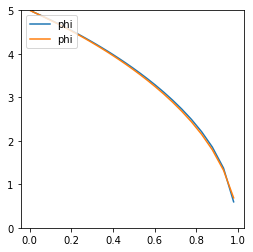

In [65]:
phi2 = CellVariable(mesh=mesh, name="phi", hasOld=True, value = 0.0)
phi2.constrain(5.0, mesh.facesLeft)
phi2.constrain(0., mesh.facesRight)

# D(phi)=D0*(1.0+phi.^2)
# dD(phi)=2.0*D0*phi
D0 = 1.0
dt= 0.01*L*L/D0 # a proper time step for diffusion process

eq2 = TransientTerm(var=phi2)-DiffusionTerm(var=phi2, coeff=D0*(1+phi2.faceValue**2))+ \
UpwindConvectionTerm(var=phi2, coeff=-2*D0*phi2.faceValue*phi2.faceGrad)== \
(-2*D0*phi2.faceValue*phi2.faceGrad*phi2.faceValue).divergence

for i in range(4):
    for i in range(5):
        c_res = eq2.sweep(dt = dt)
    phi2.updateOld()

viewer = Viewer(vars = [phi, phi2], datamax=5.0, datamin=0.0)

The above figure shows how the upwind convection term is not consistent with the linear averaging.

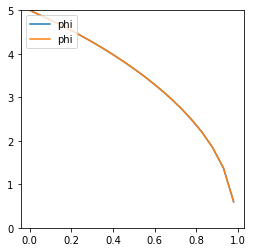

In [64]:
phi3 = CellVariable(mesh=mesh, name="phi", hasOld=True, value = 0.0)
phi3.constrain(5.0, mesh.facesLeft)
phi3.constrain(0., mesh.facesRight)

# D(phi)=D0*(1.0+phi.^2)
# dD(phi)=2.0*D0*phi
D0 = 1.0
dt= 0.01*L*L/D0 # a proper time step for diffusion process
u = -2*D0*phi3.faceValue*phi3.faceGrad

eq3 = TransientTerm(var=phi3)-DiffusionTerm(var=phi3, coeff=D0*(1+phi3.faceValue**2))+ \
UpwindConvectionTerm(var=phi3, coeff=-2*D0*phi3.faceValue*phi3.faceGrad)== \
(-2*D0*phi3.faceValue*phi3.faceGrad*phi3.faceValue).divergence

for i in range(4):
    for i in range(5):
        c_res = eq3.sweep(dt = dt)
        phi_face = FaceVariable(mesh, upwindValues(mesh, phi3, u))
        u = -2*D0*phi_face*phi3.faceGrad
        eq3 = TransientTerm(var=phi3)-DiffusionTerm(var=phi3, coeff=D0*(1+phi3.faceValue**2))+ \
            UpwindConvectionTerm(var=phi3, coeff=u)== \
            (u*phi_face).divergence
    phi3.updateOld()

viewer = Viewer(vars = [phi, phi3], datamax=5.0, datamin=0.0)